# Statics

In [1]:
import numpy as np
from numpy import linalg
from scipy import linalg
from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp


from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

from scipy.linalg import expm
from qiskit.synthesis import MatrixExponential
from qiskit.quantum_info import Kraus, SuperOp
from qiskit import Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.models import BackendProperties
from qiskit.providers.aer import noise

from qiskit.quantum_info import Statevector

from qiskit.tools.monitor import job_monitor
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit import IBMQ
from qiskit.opflow import Z, I, X, Zero, One
from qiskit.circuit.library import EfficientSU2

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

from qiskit import IBMQ, Aer
from qiskit_aer.noise import NoiseModel

from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal

from numpy import pi, array,sqrt,exp,savetxt,loadtxt

from qiskit.providers.fake_provider import FakeManila

from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter
from qiskit import Aer, assemble
from qiskit.visualization import array_to_latex
from qiskit import QuantumRegister

from qiskit.opflow.state_fns    import CircuitStateFn
from qiskit.opflow.expectations import PauliExpectation
from qiskit.utils               import QuantumInstance
from qiskit.opflow              import CircuitSampler, StateFn

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import phase_amplitude_damping_error

import matplotlib.pyplot as plt

# Computing Ground State (Classically)

The Ising model is a mathematical model of ferromagnetism in statistical mechanics.
The model consists of discrete variables that represent magnetic dipole moments of atomic spins that can be in one of two states ($+1$ or $−1$).
The spins are arranged in a graph, usually a lattice (where the local structure repeats periodically in all directions), allowing each spin to interact with its neighbors.
Neighboring spins that agree have a lower energy than those that disagree; the system tends to the lowest energy but heat disturbs this tendency, thus creating the possibility of different structural phases. 


Consider a set $\Lambda$ of lattice sites, each with a set of adjacent sites (e.g. a graph) forming a $d$-dimensional lattice.For each lattice site $k \in \Lambda$ there is a discrete variable $\sigma_k$ such that $\sigma_k \in \{+1,-1\}$, representing the site's spin. A spin configuration,$(\sigma_k)_{k \in K} \in \{-1,+1\}^K$ is an assignment of spin value to each lattice site.

For any two adjacent sites $i,j \in \Lambda$ there is an interaction $J_{ij}$. Also a site $j \in \Lambda$ has an external magnetic field hj interacting with it. The energy of a configuration σ is given by the Hamiltonian function

\begin{equation}
H(\sigma )=\sum _{\langle i~j\rangle }J_{ij}\sigma _{i}\sigma _{j}+\mu \sum _{j}h_{j}\sigma _{j}
\end{equation}

where the first sum is over pairs of adjacent spins (every pair is counted once). The notation $\langle ij \rangle$ indicates that sites $i$ and $j$ are nearest neighbors. The magnetic moment is given by $\mu$.
Ising models can be classified according to the sign of the interaction: if, for a pair i, j

- ${J_{ij}<0}$, the interaction is called ferromagnetic,
- ${J_{ij}>0}$, the interaction is called antiferromagnetic,
- ${J_{ij}=0}$, the spins are noninteracting.

Now we restrict our analisys in the following way

- Quantum case: $\sigma_i$ are Pauli matrices, precisely $\sigma^z _i$ in the first term and $\sigma^x _i$ in the second term;
- Ferromagnetic Model:${J_{ij}<0}$;
- One dimensional chain: $\Lambda$ is 1d lattice;
- Same interaction: $J_{i,j}=J$;
- Same magnetic interaction: $h_j=h$.

The hamiltonian is given by
\begin{equation}
    H=J\sum_{i }\sigma^z_i\sigma^z_{i+1}+b\sum_j\sigma^x_j
\end{equation}
where $b$ now measures the effect of a external magnetic field on the lattice.





In [2]:
#First we write the function for Ising hamiltonian
#We use qubits to represent sites

def H_ising(num_qubits,J,b):
    m=num_qubits-1
    n=num_qubits-2
    G=b*((I^m)^X)
    H=0
    hamiltonian1=H
    hamiltonian2=G
    
    for i in range(n+1):
        H =(I^i)^Z^Z^(I^(n-i))
        G=(I^i)^X^(I^(m-i))
        hamiltonian1=hamiltonian1+J*H
        hamiltonian2=hamiltonian2+b*G
    
    hamiltonian=hamiltonian1+hamiltonian2
    return hamiltonian

In [3]:
#We calculate the Eigenvalues for some values of B (magnetic field)

nShots = 8192
J = -1
b = np.linspace(0,4,10)

num_qubits=4
E_l = []
P_l = []
energy_levels = []

for k in range(len(b)):
    #In order to use linalg.eig we have to use Operator class
    hamiltonian=Operator(H_ising(num_qubits,J,b[k]))
    # Extract eig
    E_l,P_l = linalg.eig(hamiltonian.data)
    Es = np.sort(E_l)
    energy_levels.append(np.real(Es))


# Computing Ground State (Quantum)

Now we want to calculate the ground state using quantum circuits, we are going to implement VQE algorithms based on our hamiltonian and noise models.  
We split the computation in three different parts:
- Noiseless;

- Noisy, in this case we consider two different model:
    - Custom noise;
    - Hardware noise;
    
- Mitigated.

In [4]:
provider = IBMQ.enable_account('77dda7985ecda9fa85b6dcc27eea16f88f9d96e9732aea4d184e9270ec00a8f76ec5e14f289d0a7c28ab9b755d5e205e42781d238358bc64675bcc8abbda9c1f')
#provider   = IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [5]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [6]:
#Define callback function

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [7]:
#Select Hardware 

HW='ibmq_manila'

## Noiseless

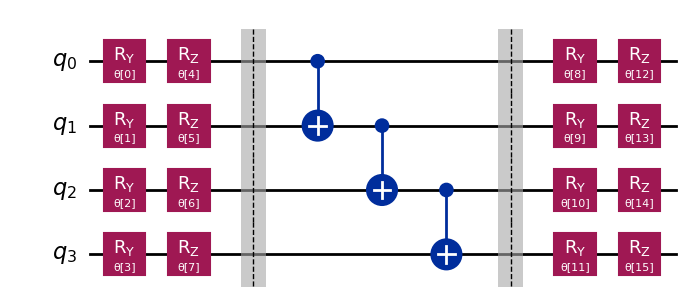

In [8]:
#Define Ansatz, on which the algorithm of VQE starts

np.random.seed(1)
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 
initial_point = np.random.random(ansatz.num_parameters)
ansatz.decompose().draw('mpl', style='iqx')

In [9]:
#We test different values of max interation for SPSA
#and we test for one COBYLA

nShots = 8192
maxiter=30
backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend,
                                       shots=nShots)
energy_30 = []
y_error_30=[]
energy_75 = []
y_error_75=[]
energy_75_cobyla = []
y_error_75_cobyla = []
energy_150 = []
y_error_150=[]

In [10]:
maxiter=30
optimizer=SPSA(maxiter=maxiter)
vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=quantum_instance,
                callback=callback)

In [11]:
#We compute the ground state for some values of B, as we have seen in the classical computation

for k in range(len(b)):
    
    hamiltonian=H_ising(num_qubits,J,b[k])
    
    # Extract eig
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    y_error_30.append(np.mean(intermediate_info['stddev']))
    energy_30.append(result.eigenvalue)


In [12]:
maxiter=75

optimizer = SPSA(maxiter=maxiter)
vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=quantum_instance,
                callback=callback)

In [13]:
for k in range(len(b)):
    
    hamiltonian=H_ising(num_qubits,J,b[k])
    
    # Extract eig
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    y_error_75.append(np.mean(intermediate_info['stddev']))
    energy_75.append(result.eigenvalue)

In [14]:
#COBYLA optimizer

maxiter=75

optimizer = COBYLA(maxiter, tol=0.001, rhobeg=1.0)
vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=quantum_instance,
                callback=callback)

In [15]:
for k in range(len(b)):
    
    hamiltonian=H_ising(num_qubits,J,b[k])
    
    # Extract eig
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    y_error_75_cobyla.append(np.mean(intermediate_info['stddev']))
    energy_75_cobyla.append(result.eigenvalue)


In [16]:
maxiter=150
optimizer = SPSA(maxiter=maxiter)

vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=quantum_instance,
                callback=callback)

In [17]:
for k in range(len(b)):
    
    hamiltonian=H_ising(num_qubits,J,b[k])
    
    # Extract eig
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    y_error_150.append(np.mean(intermediate_info['stddev']))
    energy_150.append(result.eigenvalue)


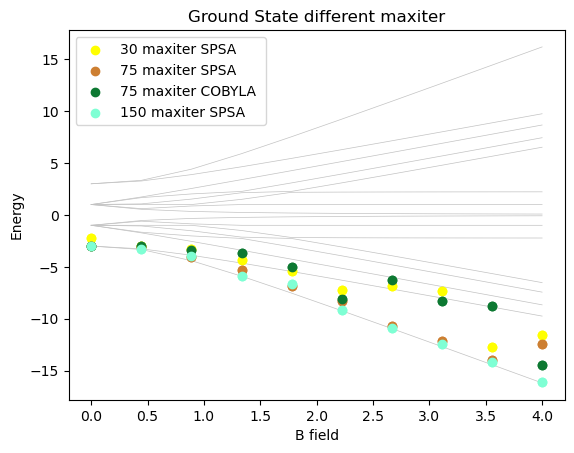

In [19]:
#We plot the ground state for different maxiter and optimizer

fig, ax = plt.subplots()

ax.scatter(b, energy_30,color="yellow",label='30 maxiter SPSA')
ax.scatter(b, energy_75, color="#CD7F32",label='75 maxiter SPSA')
ax.scatter(b, energy_75_cobyla,color="#0D7932",label='75 maxiter COBYLA ')
ax.scatter(b, energy_150, color="#7FFFD4",label='150 maxiter SPSA')

plt.legend()

plt.errorbar(b, energy_30, yerr=y_error_30, fmt="o",color="yellow")
plt.errorbar(b, energy_75, yerr=y_error_75, fmt="o",color="#CD7F32")
plt.errorbar(b, energy_75_cobyla, yerr=y_error_75_cobyla, fmt="o",color="#0D7932")
plt.errorbar(b, energy_150, yerr=y_error_150, fmt="o",color="#7FFFD4")

ax.plot(b, energy_levels, color="#c2c2c2", linewidth=.5)

ax.set(xlabel='B field', ylabel='Energy',title='Ground State different maxiter')

plt.show()

### Other parameters 

Now we want to test different parameters for the algorithm.
The parameters that we can modify are essentially in ansatz and optimizer.  
Since we've already delt with the optimizer, we can modify the ansatz through its options
- Entanglement;
- Repetitions.


In [19]:
#We start from entanglement
#We fix 75 max iterations and SPSA
energy_75_c = []
y_error_75_c=[]
energy_75_cr = []
y_error_75_cr=[]
energy_75_f= []
y_error_75_f=[]


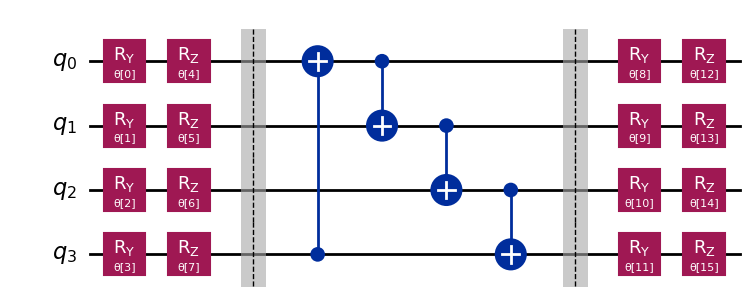

In [20]:
#Ansatz circular entanglement
np.random.seed(1)
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='circular', insert_barriers=True) 
initial_point = np.random.random(ansatz.num_parameters)
ansatz.decompose().draw('mpl', style='iqx')

In [21]:
maxiter=75

optimizer = SPSA(maxiter=maxiter)
vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=quantum_instance,
                callback=callback)

In [22]:
for k in range(len(b)):
    
    hamiltonian=H_ising(num_qubits,J,b[k])
    
    # Extract eig
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    y_error_75_c.append(np.mean(intermediate_info['stddev']))
    energy_75_c.append(result.eigenvalue)

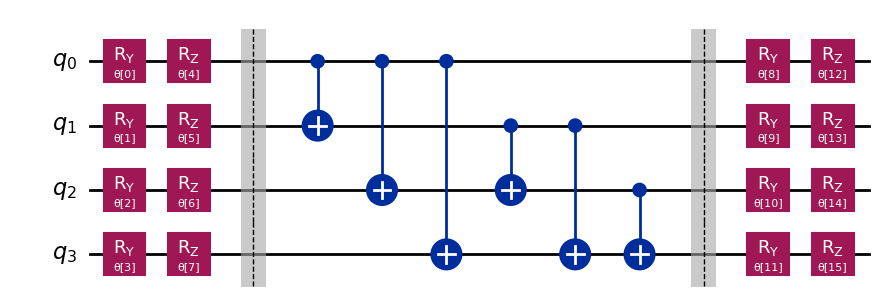

In [23]:
#Ansatz circular entanglement
np.random.seed(1)
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='full', insert_barriers=True) 
initial_point = np.random.random(ansatz.num_parameters)
ansatz.decompose().draw('mpl', style='iqx')

In [24]:
maxiter=75

optimizer = SPSA(maxiter=maxiter)
vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=quantum_instance,
                callback=callback)

In [25]:
for k in range(len(b)):
    
    hamiltonian=H_ising(num_qubits,J,b[k])
    
    # Extract eig
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    y_error_75_f.append(np.mean(intermediate_info['stddev']))
    energy_75_f.append(result.eigenvalue)

C:\Users\Fabio\anaconda3\lib\site-packages\matplotlib\collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


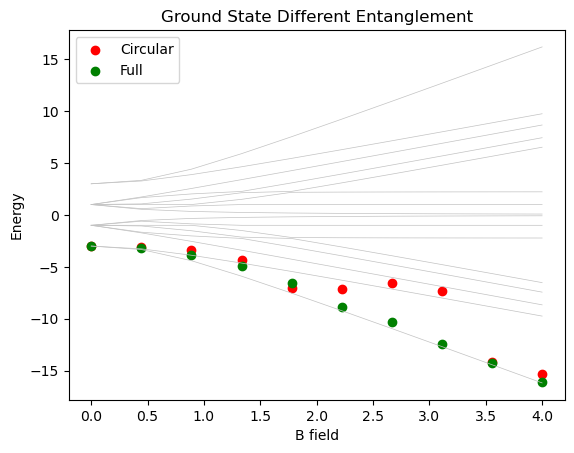

In [26]:
fig, full=plt.subplots()


full.scatter(b, energy_75_c,color='red',label='Circular')
full.scatter(b, energy_75_f, color='green', label='Full')
full.plot(b, energy_levels, color="#c2c2c2", linewidth=.5)
full.set(xlabel='B field', ylabel='Energy', title='Ground State Different Entanglement')

plt.legend()

plt.show()


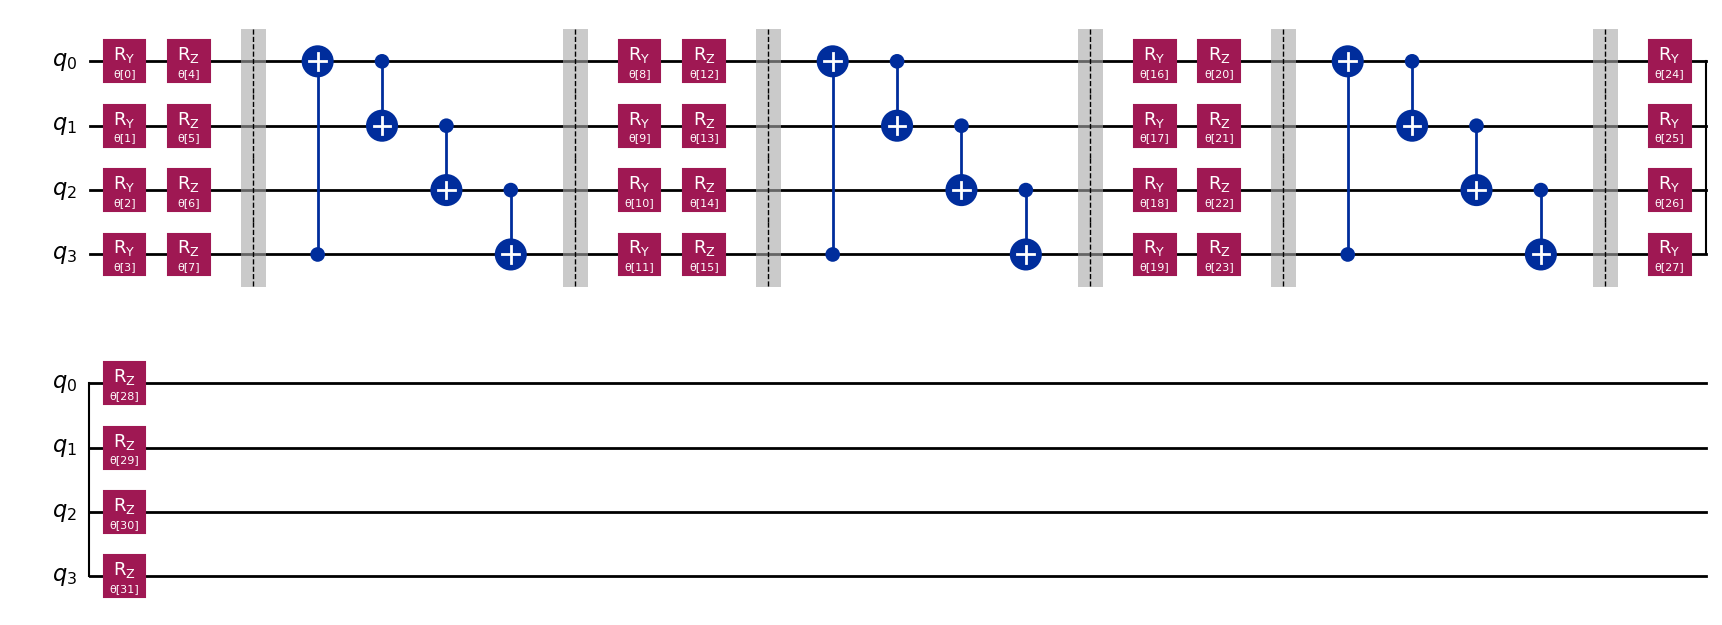

In [27]:
#Ansatz: circular entanglement, 3 repetitions
np.random.seed(1)
ansatz = EfficientSU2(num_qubits, reps=3, entanglement='circular', insert_barriers=True) 
initial_point = np.random.random(ansatz.num_parameters)
ansatz.decompose().draw('mpl', style='iqx')

In [28]:
maxiter=75

optimizer = SPSA(maxiter=maxiter)
vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=quantum_instance,
                callback=callback)

In [29]:
for k in range(len(b)):
    
    hamiltonian=H_ising(num_qubits,J,b[k])
    
    # Extract eig
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    y_error_75_cr.append(np.mean(intermediate_info['stddev']))
    energy_75_cr.append(result.eigenvalue)

C:\Users\Fabio\anaconda3\lib\site-packages\matplotlib\collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


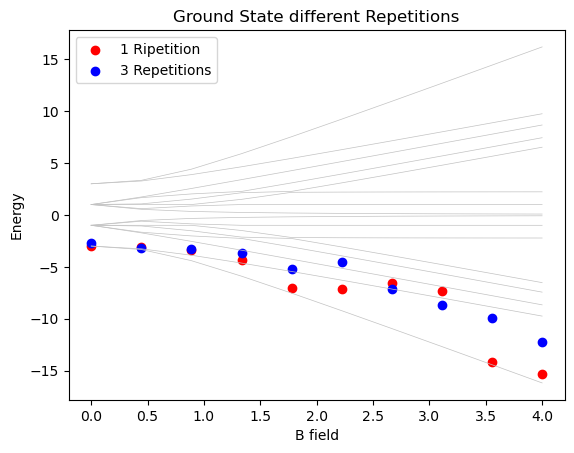

In [30]:
fig, cir= plt.subplots()


cir.scatter(b, energy_75_c,color='red',label='1 Ripetition')
cir.plot(b, energy_levels, color="#c2c2c2", linewidth=.5)
cir.set(xlabel='B field', ylabel='Energy', title='Ground State different Repetitions')

cir.scatter(b, energy_75_cr, label='3 Repetitions', color='blue')

plt.legend()


plt.show()

## Noisy

For the noisy simulation we consider the hardware `ibmq_manila` .  
In this computation we begin creating a new noise model, based on backend properties which contains:
- read out error;
- single qubit depolarizing;
- single qubit relaxation;
- two qubits relaxation;
- two qubits depolarizing.

Then we consider the noise model from hardware properties.

### Custom Noise Models

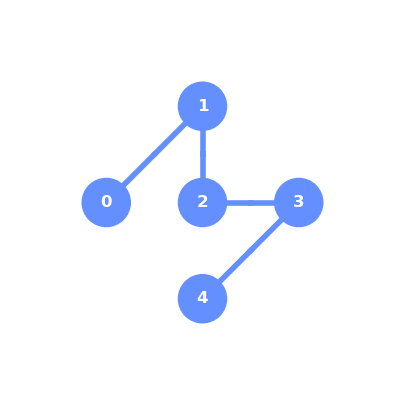

In [31]:
from qiskit.visualization import plot_histogram, plot_gate_map
backend = provider.get_backend(HW)
plot_gate_map(backend)

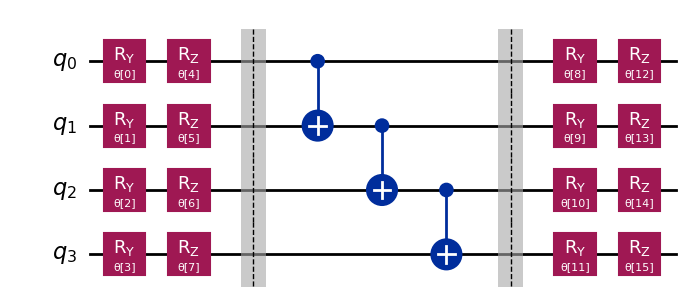

In [32]:
#We define a linear ansatz and 1 reps
np.random.seed(1)
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 
initial_point = np.random.random(ansatz.num_parameters)
ansatz.decompose().draw('mpl', style='iqx')

In [33]:
def noise_model(backend,qubits_layout):
    
    p_reset = 0.333
 
    tg = 35 * 10**(-9)
    
    nqubit = len(qubits_layout)
    
    noise_model = NoiseModel()
    
    prop = backend.properties()
    
    t_cnot = np.zeros((nqubit,nqubit))
        
    p_cnot = np.zeros((nqubit,nqubit))
    
    #Read from backend

    T1 = [prop.t1(j) for j in qubits_layout] #T1 qubits backhand
    T2 = [prop.t2(j) for j in qubits_layout]  #T2 qubits backhand
    p = [prop.gate_error('x',[j]) for j in qubits_layout] #x dep error for each qubit
    rout = [prop.readout_error(j) for j in qubits_layout] #readout error for each qubit

    if (nqubit > 1):
        for i in range(0,nqubit):
            if (i == 0):
                t_cnot[0][1] = prop.gate_length('cx',[qubits_layout[0],qubits_layout[1]]) #Gate length for cnot
                p_cnot[0][1] = prop.gate_error('cx',[qubits_layout[0],qubits_layout[1]]) #Gate dep error for cnot
            if (i != 0 and i != nqubit-1):
                t_cnot[i][i-1] = prop.gate_length('cx',[qubits_layout[i],qubits_layout[i-1]])
                p_cnot[i][i-1] = prop.gate_error('cx',[qubits_layout[i],qubits_layout[i-1]])
                t_cnot[i][i+1] = prop.gate_length('cx',[qubits_layout[i],qubits_layout[i+1]])
                p_cnot[i][i+1] = prop.gate_error('cx',[qubits_layout[i],qubits_layout[i+1]])
            if (i == nqubit-1):
                t_cnot[i][i-1] = prop.gate_length('cx',[qubits_layout[i],qubits_layout[i-1]])
                p_cnot[i][i-1] = prop.gate_error('cx',[qubits_layout[i],qubits_layout[i-1]])
    
   
        
    for j in range(0,nqubit):
        
        #single qubit depolarizing
        
        dep = depolarizing_error(p[j],1)# input: prob, num_qubit
        
        #single qubit relaxation
        
        Tph = T1[j] * T2[j] / (2 * T1[j] - T2[j]) 
        p1 = 1 - exp(-tg/T1[j]) #probability of dephasing in time tg
        p_ph = 1 - exp(-tg/Tph) 
        pz = (1 - p1) * p_ph 
          
        relax = phase_amplitude_damping_error(p1,pz)
        
        #spam
          
        spam = pauli_error([('X',rout[j]), ('I', 1 - rout[j])]) #readout error 
        
        #adding errors to noise model
        
        single_qubit_gate_error = dep.compose(relax)
        
        noise_model.add_quantum_error(single_qubit_gate_error, ["x","sx"],[qubits_layout[j]])
        
        noise_model.add_quantum_error(spam, "measure",[qubits_layout[j]])
        

        
    for j in range(0,nqubit):
        for k in range(0,nqubit):
            if (k == j+1 or k == j-1):
                
                #two qubits relaxation
            
                Tph_j = T1[j] * T2[j] / (2 * T1[j] - T2[j])
                p1_j = 1 - exp(-t_cnot[j][k]/T1[j]) #prob damping
                p_ph_j = 1 - exp(-t_cnot[j][k]/Tph_j) #prob dephasing
                pz_j = (1 - p1_j) * p_ph_j #prob damping and dephasing
                
                Tph_k = T1[k] * T2[k] / (2 * T1[k] - T2[k])
                p1_k = 1 - exp(-t_cnot[j][k]/T1[k])
                p_ph_k = 1 - exp(-t_cnot[j][k]/Tph_k)
                pz_k = (1 - p1_k) * p_ph_k
        
                relax_j = phase_amplitude_damping_error(p1_j,pz_j)
                relax_k = phase_amplitude_damping_error(p1_k,pz_k)
                relax_jk = relax_k.tensor(relax_j)
   
                
                #two qubits depolarizing
                
                dep_j = depolarizing_error(p_cnot[j][k],1)
                dep_k = depolarizing_error(p_cnot[j][k],1)
                dep_cnot = dep_k.tensor(dep_j) 
                
                #adding errors to noise model
                
                two_qubits_gate_error = dep_cnot.compose(relax_jk)
                
                noise_model.add_quantum_error(two_qubits_gate_error, "cx",[qubits_layout[j],qubits_layout[k]])
                
   
    
    for j in range(0,nqubit):
        error=thermal_relaxation_error(T1[qubits_layout[j]],T2[qubits_layout[j]], tg)
        noise_model.add_quantum_error(error, ['id'], [qubits_layout[j]])#thermal relaxation error
    

    error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
    noise_model.add_all_qubit_quantum_error(error_reset, "reset")# reset error 

    
    return noise_model

In [34]:
#We build quantum instance based on our custom noise

optimizer = SPSA(maxiter=150)
device = provider.get_backend(HW)
coupling_map = device.configuration().coupling_map
prop = device.properties()
noise_model_custom = noise_model(device,[i for i in range(5)])
backend = Aer.get_backend('qasm_simulator')
basis_gates = noise_model_custom.basis_gates
quantum_instance = QuantumInstance(backend,
                                       shots=nShots,
                                       basis_gates=basis_gates,
                                       noise_model=noise_model_custom,
                                       coupling_map=coupling_map)


In [35]:
print(noise_model_custom)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['id', 'cx', 'sx', 'reset', 'measure', 'x']
  Qubits with noise: [0, 1, 2, 3, 4]
  All-qubits errors: ['reset']
  Specific qubit errors: [('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (3, 4)), ('cx', (4, 3)), ('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,))]


In [36]:
vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=quantum_instance,
                callback=callback)

In [37]:
energy_noisy_custom= []
y_error_noisy_custom=[]

for k in range(len(b)):
    
    hamiltonian=H_ising(num_qubits,J,b[k])
    
    # Extract eig
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    y_error_noisy_custom.append(np.mean(intermediate_info['stddev']))
    energy_noisy_custom.append(result.eigenvalue)

C:\Users\Fabio\anaconda3\lib\site-packages\matplotlib\collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
C:\Users\Fabio\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Fabio\anaconda3\lib\site-packages\numpy\ma\core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


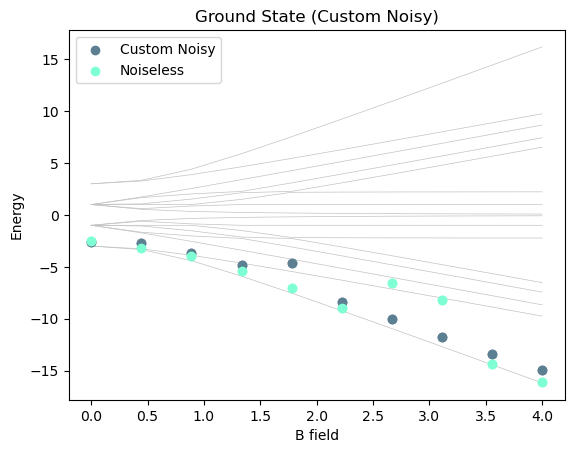

In [38]:
fig, ax = plt.subplots()

ax.scatter(b, energy_noisy_custom,color="#5D7F92",label='Custom Noisy')
ax.scatter(b, energy_150, color="#7FFFD4",label='Noiseless')

#Error

plt.errorbar(b, energy_noisy_custom, yerr=y_error_30, fmt="o",color="#5D7F92")
plt.errorbar(b, energy_150, yerr=y_error_150, fmt="o",color="#7FFFD4")

ax.plot(b, energy_levels, color="#c2c2c2", linewidth=.5)

ax.set(xlabel='B field', ylabel='Energy', title='Ground State (Custom Noisy)')

plt.legend()


plt.show()


In [39]:
err =np.zeros(len(b))

for k in range(len(b)):
    err[k]=energy_150[k]-energy_noisy_custom[k]

mean_err=np.mean(err)

print("Mean error noisy and noiseless:", mean_err)

Mean error noisy and noiseless: 0.06776529947916639


C:\Users\Fabio\AppData\Local\Temp\ipykernel_17032\2526729352.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  err[k]=energy_150[k]-energy_noisy_custom[k]


### Hardware Noise Models

In [40]:
#Quantum instance based on the hardware model

optimizer = SPSA(maxiter=150)
device = provider.get_backend(HW)
coupling_map = device.configuration().coupling_map
prop = device.properties()
noise_model = NoiseModel.from_backend(device)  #Noise model from backend
backend = Aer.get_backend('qasm_simulator')
basis_gates = noise_model.basis_gates
quantum_instance = QuantumInstance(backend,
                                       shots=nShots,
                                       basis_gates=basis_gates,
                                       noise_model=noise_model,
                                       coupling_map=coupling_map)

In [41]:
vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=quantum_instance,
                callback=callback)

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['id', 'cx', 'sx', 'reset', 'measure', 'x']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [42]:
energy_noisy= []
y_error_noisy=[]

for k in range(len(b)):
    
    hamiltonian=H_ising(num_qubits,J,b[k])
    
    # Extract eig
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    y_error_noisy.append(np.mean(intermediate_info['stddev']))
    energy_noisy.append(result.eigenvalue)

C:\Users\Fabio\anaconda3\lib\site-packages\matplotlib\collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
C:\Users\Fabio\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Fabio\anaconda3\lib\site-packages\numpy\ma\core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


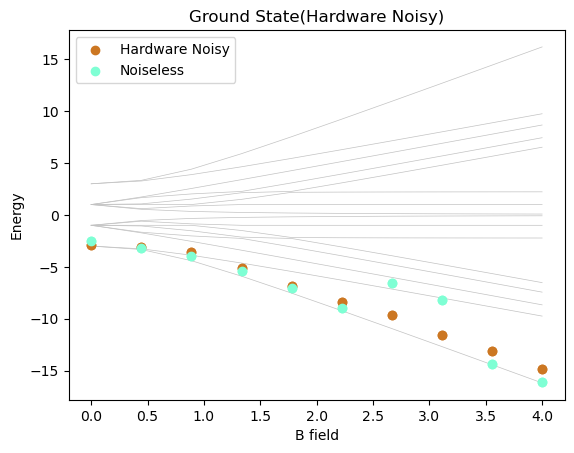

In [43]:
fig, ax = plt.subplots()

ax.scatter(b, energy_noisy,color="#CC7722",label='Hardware Noisy')
ax.scatter(b, energy_150, color="#7FFFD4",label='Noiseless')

#Error

plt.errorbar(b, energy_noisy, yerr=y_error_30, fmt="o",color="#CC7722")
plt.errorbar(b, energy_150, yerr=y_error_150, fmt="o",color="#7FFFD4")

ax.plot(b, energy_levels, color="#c2c2c2", linewidth=.5)

ax.set(xlabel='B field', ylabel='Energy', title='Ground State(Hardware Noisy)')

plt.legend()


plt.show()


In [44]:
err =np.zeros(len(b))

for k in range(len(b)):
    err[k]=np.real(energy_150[k])-energy_noisy[k]

mean_err=np.mean(err)

print("Mean error noisy and noiseless:", mean_err)

Mean error noisy and noiseless: 0.2676730685763884


C:\Users\Fabio\AppData\Local\Temp\ipykernel_17032\1888347260.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  err[k]=np.real(energy_150[k])-energy_noisy[k]


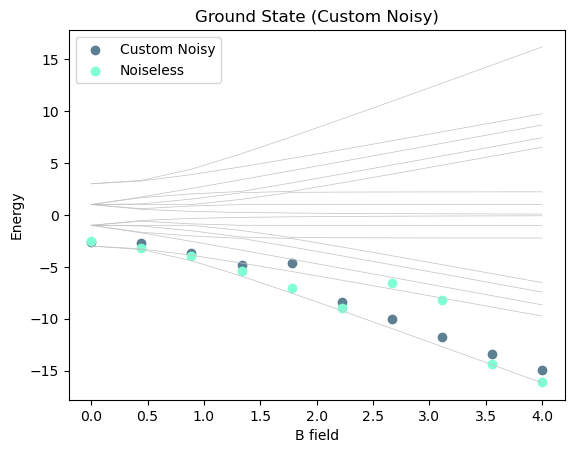

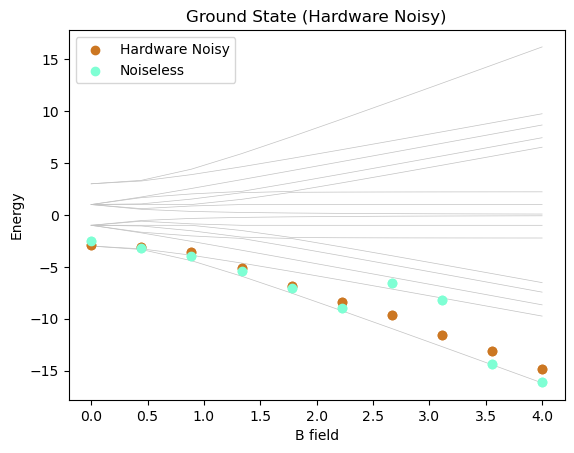

In [45]:
fig1, ac = plt.subplots()
fig2, ah = plt.subplots()

ac.scatter(b, energy_noisy_custom,color="#5D7F92",label='Custom Noisy')
ac.scatter(b, energy_150, color="#7FFFD4",label='Noiseless')

ac.plot(b, energy_levels, color="#c2c2c2", linewidth=.5)
ac.set(xlabel='B field', ylabel='Energy', title='Ground State (Custom Noisy)')

ah.scatter(b, energy_noisy,color="#CC7722",label='Hardware Noisy')
ah.scatter(b, energy_150, color="#7FFFD4",label='Noiseless')

#Error

plt.errorbar(b, energy_noisy, yerr=y_error_30, fmt="o",color="#CC7722")
plt.errorbar(b, energy_150, yerr=y_error_150, fmt="o",color="#7FFFD4")

ah.plot(b, energy_levels, color="#c2c2c2", linewidth=.5)

ah.set(xlabel='B field', ylabel='Energy', title='Ground State (Hardware Noisy)')

ac.legend()

ah.legend()



plt.show()

## Mitigated

### Custom Noise Mitigation

In [46]:
from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter
from qiskit import QuantumRegister
from qiskit import Aer, assemble
from qiskit.visualization import array_to_latex

qr = QuantumRegister(4)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

custom_sim = Aer.get_backend('qasm_simulator',noise_model=noise_model_custom)

t_qc = transpile(meas_calibs,custom_sim)

qobj = assemble(t_qc, shots=10000)
cal_results = custom_sim.run(qobj, noise_model=noise_model_custom, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print("Conversion Matrix Custom")
array_to_latex(meas_fitter.cal_matrix)

Conversion Matrix Custom


<IPython.core.display.Latex object>

In [47]:
#Computation using error mitigation through quantum_instance option
optimizer = SPSA(maxiter=150)
###############################

backend = Aer.get_backend('qasm_simulator')
device = provider.get_backend(HW)
noise_model = noise_model_custom
basis_gates = noise_model.basis_gates
coupling_map = device.configuration().coupling_map
quantum_instance = QuantumInstance(backend,
                                       shots=nShots,
                                       basis_gates=basis_gates,
                                       coupling_map=coupling_map,
                                       noise_model=noise_model,
                                       measurement_error_mitigation_cls=CompleteMeasFitter)#Complete measurement fitter

In [48]:
vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=quantum_instance,
                callback=callback)

In [49]:
energy_mitigated= []

y_error_mitigated=[]

for k in range(len(b)):
    
    hamiltonian=H_ising(num_qubits,J,b[k])
    
    # Extract eig
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    y_error_mitigated.append(np.mean(intermediate_info['stddev']))
    energy_mitigated.append(result.eigenvalue)

C:\Users\Fabio\anaconda3\lib\site-packages\matplotlib\collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
C:\Users\Fabio\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Fabio\anaconda3\lib\site-packages\numpy\ma\core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


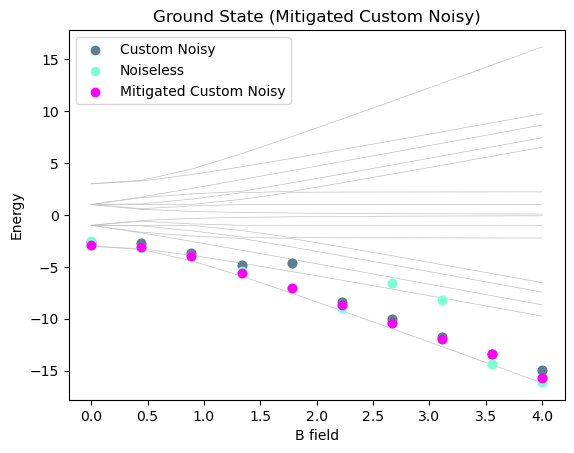

In [50]:
fig, ax = plt.subplots()

ax.scatter(b, energy_noisy_custom,color="#5D7F92",label='Custom Noisy')
ax.scatter(b, energy_150, color="#7FFFD4",label='Noiseless')
ax.scatter(b, energy_mitigated, color="magenta", label='Mitigated Custom Noisy')

ax.plot(b, energy_levels, color="#c2c2c2", linewidth=.5)
ax.set(xlabel='B field', ylabel='Energy', title='Ground State (Mitigated Custom Noisy)')

#Error

plt.errorbar(b, energy_noisy_custom, yerr=y_error_30, fmt="o",color="#5D7F92")
plt.errorbar(b, energy_150, yerr=y_error_150, fmt="o",color="#7FFFD4")
plt.errorbar(b, energy_mitigated, yerr=y_error_mitigated,color="magenta", fmt="o")


plt.legend()


plt.show()


### Hardware Noise Mitigation

In [51]:
#Computation using error mitigation through quantum_instance option
optimizer = SPSA(maxiter=150)
###############################

backend = Aer.get_backend('qasm_simulator')
device = provider.get_backend(HW)
noise_model=NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates
coupling_map = device.configuration().coupling_map
quantum_instance = QuantumInstance(backend,
                                       shots=nShots,
                                       basis_gates=basis_gates,
                                       coupling_map=coupling_map,
                                       noise_model=noise_model,
                                       measurement_error_mitigation_cls=CompleteMeasFitter)#Complete measurement fitter

In [52]:
from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter
from qiskit import QuantumRegister
from qiskit import Aer, assemble
from qiskit.visualization import array_to_latex

qr = QuantumRegister(4)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

custom_sim = Aer.get_backend('qasm_simulator',noise_model=noise_model)

t_qc = transpile(meas_calibs,custom_sim)

qobj = assemble(t_qc, shots=10000)
cal_results = custom_sim.run(qobj, noise_model=noise_model, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print("Conversion Matrix")
array_to_latex(meas_fitter.cal_matrix)

Conversion Matrix


<IPython.core.display.Latex object>

In [53]:
vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=quantum_instance,
                callback=callback)

In [54]:
energy_mitigated_hardware= []

y_error_mitigated_hardware=[]

for k in range(len(b)):
    
    hamiltonian=H_ising(num_qubits,J,b[k])
    
    # Extract eig
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    y_error_mitigated_hardware.append(np.mean(intermediate_info['stddev']))
    energy_mitigated_hardware.append(result.eigenvalue)


C:\Users\Fabio\anaconda3\lib\site-packages\matplotlib\collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
C:\Users\Fabio\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Fabio\anaconda3\lib\site-packages\numpy\ma\core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


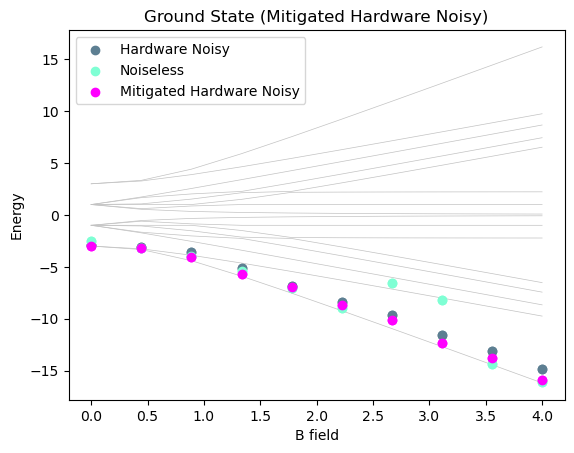

In [55]:
fig, ax = plt.subplots()

ah.scatter(b, energy_noisy,color="#CC7722",label='Hardware Noisy')
ax.scatter(b, energy_150, color="#7FFFD4",label='Noiseless')
ax.scatter(b, energy_mitigated_hardware, color="magenta", label='Mitigated Hardware Noisy')

ax.plot(b, energy_levels, color="#c2c2c2", linewidth=.5)
ax.set(xlabel='B field', ylabel='Energy', title='Ground State (Mitigated Hardware Noisy)')

#Error
plt.errorbar(b, energy_noisy, yerr=y_error_30, fmt="o",color="#CC7722")
plt.errorbar(b, energy_150, yerr=y_error_150, fmt="o",color="#7FFFD4")
plt.errorbar(b, energy_mitigated_hardware, yerr=y_error_mitigated_hardware,color="magenta", fmt="o")


plt.legend()


plt.show()


## Classical Equilibrium Statistics

At equilibrium, the configuration probability is given by the Boltzmann distribution with inverse temperature $\beta \geq 0$:
\begin{equation}
P_{\beta }(\sigma )={\frac {e^{-\beta H(\sigma )}}{Z_{\beta }}},
\end{equation}
where $\beta = (k_BT)^{-1}$, and the normalization constant
\begin{equation}
Z_{\beta }=\sum _{\sigma }e^{-\beta H(\sigma )}
\end{equation}
is the partition function. For a function $f$ of the spins ("observable"), one denotes by
\begin{equation}
\langle f\rangle _{\beta }=\sum _{\sigma }f(\sigma )P_{\beta }(\sigma )
\end{equation}
the expectation (mean) value of $f$.

Now we want to compute classical state probabilities via classical computation and via quantum computation.  
The classical part consists in **evaluating** the energy mean value for each computational base vector $\sigma_i \in \{| 0000\rangle,|0001\rangle, ... , |1111\rangle \}$
\begin{equation}
\langle H_i\rangle = \langle \sigma_i|H|\sigma_i\rangle.
\end{equation}

In this way we can sum over the configuarations and we get
\begin{equation}
Z_{\beta }=\sum _{\sigma }e^{-\beta H(\sigma )}
\end{equation}


The quantum part consists in **measuring** the energy mean value for each computational base vector 
\begin{equation}
\langle H_i\rangle = \langle \sigma_i|H|\sigma_i\rangle.
\end{equation}
We will prepare a quantum circuit to do so.


### Classical Evaluation

In [56]:
#Fix temperature at 300K
#We fix k_b in electronvolt; we didn't put units in hamiltonian

T=3000
k=8.6*10**(-5)
beta=(k*T)**(-1)

nShots = 8192
J = -1
b = 4
num_qubits=4

In [57]:
h=H_ising(num_qubits,J,b)

In [58]:
#Build computational basis

basis=[]

n=num_qubits-1

for k in range(2**num_qubits):
    basis.append(Zero if k%2==0 else One)

for i in range (2**num_qubits):
    if (i)%4==0:
        basis[i]=Zero^basis[i]
    elif (i)%4==1:
         basis[i]=Zero^basis[i]
    else:
        basis[i]=One^basis[i]

for i in range (2**num_qubits):
    if (i)%8==0:
         basis[i]=Zero^basis[i]
    elif (i)%8==1:
         basis[i]=Zero^basis[i]
    elif (i)%8==2:
        basis[i]=Zero^basis[i]
    elif (i)%8==3:
        basis[i]=Zero^basis[i]
    else:
        basis[i]=One^basis[i]

for i in range (2**n):
    basis[i]=Zero^basis[i]
    
for i in range (2**n,2**num_qubits):
    basis[i]=One^basis[i]

In [59]:
#Evaluate energy mean value 
E=[]

for k in range(2**num_qubits):
    E.append((~basis[k] @ H_ising(num_qubits,J,b) @ basis[k]).eval())

In [60]:
#Caculate partition function
zeta=0

for k in range(2**num_qubits):
    zeta=zeta+exp(-beta*np.real(E[k]))

In [61]:
#Equilibrium probabilities

print("Equilibrium probabilities:\n")
for i in range(2**num_qubits):
    print("State",i, np.real(exp(-beta*E[i])/zeta))

Equilibrium probabilities:

State 0 0.4993556912022634
State 1 0.00021467729440983855
State 2 9.229161006289861e-08
State 3 0.00021467729440983855
State 4 9.229161006289861e-08
State 5 3.9676954712038524e-11
State 6 9.229161006289861e-08
State 7 0.00021467729440983855
State 8 0.00021467729440983855
State 9 9.229161006289861e-08
State 10 3.9676954712038524e-11
State 11 9.229161006289861e-08
State 12 0.00021467729440983855
State 13 9.229161006289861e-08
State 14 0.00021467729440983855
State 15 0.4993556912022634


### Quantum Measure

In [62]:
#Build computational basis

circ=[]
reg=[]

n=num_qubits-1

for k in range(2**num_qubits):
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)
    if k%2==1:
        qc.x(0)
        circ.append(qc)
    else:
        circ.append(qc)

for i in range (2**num_qubits):
    if (i)%4==2:
        circ[i].x(1)
    elif (i)%4==3:
         circ[i].x(1)

for i in range (2**num_qubits):
    if (i)%8==4:
         circ[i].x(2)
    elif (i)%8==5:
         circ[i].x(2)
    elif (i)%8==6:
        circ[i].x(2)
    elif (i)%8==7:
        circ[i].x(2)
    
for i in range (2**n,2**num_qubits):
    circ[i].x(3)

In [63]:
#Evaluate energy of computational basis

E_q = []



ob = StateFn(h,is_measurement = True)

backend     = QasmSimulator(shots=nShots)
expectation = PauliExpectation()
sampler     = CircuitSampler(backend)


for i in range(2**num_qubits):
    measured_qc  = expectation.convert(ob @ StateFn((circ[i])))
    sampled_op = sampler.convert(measured_qc)
    E_q.append(sampled_op.eval().real)

In [64]:
zeta_q=0

for k in range(2**num_qubits):
    zeta_q=zeta_q+exp(-beta*np.real(E_q[k]))

zeta_q

216342.55061050164

In [65]:
for i in range(2**num_qubits):
    print("State",i, np.real(exp(-beta*E_q[i])/zeta_q))

State 0 0.2862252721560216
State 1 0.00019675357950519332
State 2 7.353192854969544e-08
State 3 0.0001769679341495845
State 4 1.4867357697447204e-07
State 5 3.055324424857237e-11
State 6 6.638833164267661e-08
State 7 0.00016720016101027418
State 8 0.00023955394478746142
State 9 1.567645358217307e-07
State 10 4.6507791479388104e-11
State 11 1.1450053005699447e-07
State 12 0.0001908849847426984
State 13 6.154808833328817e-08
State 14 0.00014981826764281432
State 15 0.712652927488088


## Quantum Equilibrium Statistics

Now let's extend the statistical analysis to the quantum case.
Consider a density matrix at the equilibrium, i.e.
\begin{equation}
\rho=\frac{e^{-\beta H}}{\mathrm{Tr}[{e^{-\beta H}}]}
.
\end{equation}

We are interested in the analysis of state probabilities of Bloch space via classical computation and via quantum computation.  
For the classical computation, we use the formula

$$
\mathbb{P}(\sigma_i)=\langle \rho_i \rangle=\mathrm{Tr}[\rho_i\rho ].  
$$

For the quantum computation, we intend to evaluate the density matrix on the computational base:

$$
\mathbb{P}(\sigma_i)=\langle \sigma_i |\rho| \sigma_i\rangle .
$$

In both cases it corrisponds to the diagonal of the density matrix, which tells us the probability of finding the i-th configuration of the system in equilibrium.

### Classical Evaluation

In [66]:
h1=Operator(h)
expmatrix=linalg.expm(-beta*h1)
trace=expmatrix.trace()
density=qi.DensityMatrix(expmatrix/trace)
densityOp=Operator(density)

h1.is_unitary()

density.draw('latex', prefix='\\rho_{\\beta} = ')


<IPython.core.display.Latex object>

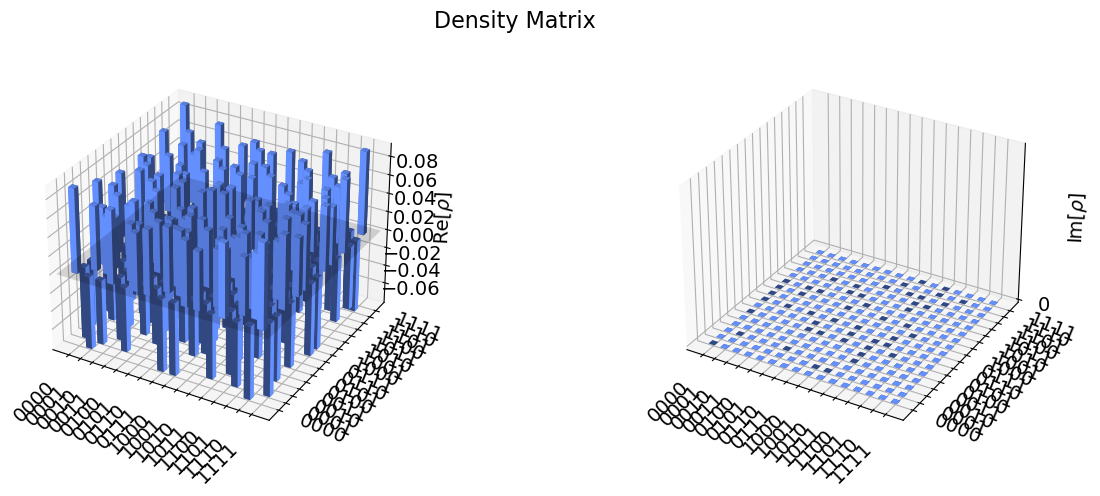

In [67]:
from qiskit.visualization import plot_state_city
plot_state_city(density.data, title='Density Matrix')

In [68]:
#Build computational basis

basisOp=[]

n=num_qubits-1

for k in range(2**num_qubits):
    basisOp.append(1/16*(I-Z) if k%2==0 else 1/16*(I+Z))

for i in range (2**num_qubits):
    if (i)%4==0:
        basisOp[i]=(I-Z)^ basisOp[i]
    elif (i)%4==1:
        basisOp[i]=(I-Z)^ basisOp[i]
    else:
        basisOp[i]=(I+Z)^ basisOp[i]

for i in range (2**num_qubits):
    if (i)%8==0:
         basisOp[i]=(I-Z)^ basisOp[i]
    elif (i)%8==1:
         basisOp[i]=(I-Z)^ basisOp[i]
    elif (i)%8==2:
        basisOp[i]=(I-Z)^ basisOp[i]
    elif (i)%8==3:
        basisOp[i]=(I-Z)^ basisOp[i]
    else:
        basisOp[i]=(I-Z)^ basisOp[i]

for i in range (2**n):
    basisOp[i]=(I-Z)^ basisOp[i]
    
for i in range (2**n,2**num_qubits):
    basisOp[i]=(I+Z)^ basisOp[i]

In [69]:
#Computation using <A>=Tr[\rho A]
#In this case the observable is the density matrix for a single state
Prob=[]

for state in basis:
    rho_p = Operator(qi.DensityMatrix(state))
    Prob.append(np.trace(densityOp@rho_p))


for i in range(2**num_qubits):
    print("State",i, Prob[i])


State 0 (0.09020581071512059+0j)
State 1 (0.06908764911224972+0j)
State 2 (0.053944748413319366+0j)
State 3 (0.06801253454343721+0j)
State 4 (0.05394474841331933+0j)
State 5 (0.042611578036026526+0j)
State 6 (0.05310528165427707+0j)
State 7 (0.06908764911224985+0j)
State 8 (0.06908764911224982+0j)
State 9 (0.05310528165427698+0j)
State 10 (0.0426115780360266+0j)
State 11 (0.05394474841331933+0j)
State 12 (0.06801253454343735+0j)
State 13 (0.05394474841331937+0j)
State 14 (0.06908764911225+0j)
State 15 (0.09020581071512082+0j)


### Quantum Measure

In [70]:
Prob_q = []
backend     = QasmSimulator(shots=nShots)
expectation = PauliExpectation()
sampler     = CircuitSampler(backend)


ob=StateFn(densityOp, is_measurement=True)
 
for i in range(2**num_qubits):
    measured_qc  = expectation.convert(ob @ StateFn((circ[i])))   
    sampled_op = sampler.convert(measured_qc)
    Prob_q.append(sampled_op.eval().real) 
    

    
for i in range(2**num_qubits):
    print("State",i, Prob_q[i])

sum(Prob_q)

TypeError: Unsupported primitive type <class 'qiskit.quantum_info.operators.operator.Operator'> passed into StateFn factory constructor

## Varying qubits number

We have worked with just 4 sites, let's plot the ground state for 5, 6, 7 sites.

In [71]:
nShots = 8192
J = -1
b = np.linspace(0,4,10)

num_qubits=5
E_l_5 = []
P_l_5 = []
energy_levels_5 = []

for k in range(len(b)):
    hamiltonian=Operator(H_ising(num_qubits,J,b[k]))
    
    # Extract eig
    E_l_5,P_l_5 = linalg.eig(hamiltonian.data)

    Es_5 = np.sort(E_l_5)

    energy_levels_5.append(np.real(Es_5))

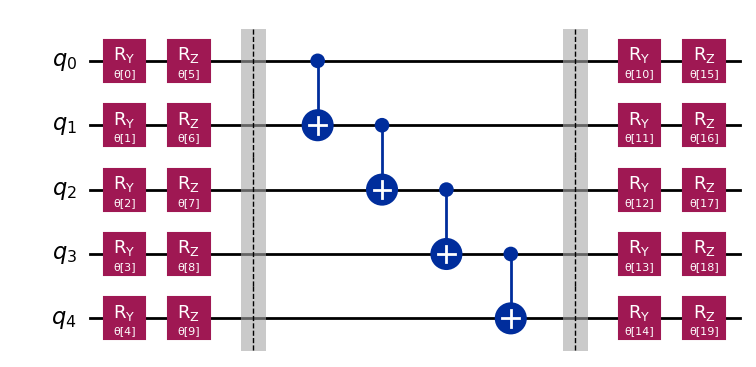

In [72]:
np.random.seed(1)
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 
initial_point = np.random.random(ansatz.num_parameters)
ansatz.decompose().draw('mpl', style='iqx')

In [73]:
nShots = 8192
maxiter=300
backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend,
                                       shots=nShots)
energy_5 = []
y_error_5=[]
energy_6= []
y_error_6=[]
energy_7 = []
y_error_7=[]

In [74]:
optimizer=SPSA(maxiter=maxiter)
vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=quantum_instance,
                callback=callback)

In [75]:
for k in range(len(b)):
    
    hamiltonian=H_ising(num_qubits,J,b[k])
    
    # Extract eig
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    y_error_5.append(np.mean(intermediate_info['stddev']))
    energy_5.append(result.eigenvalue)

In [76]:
nShots = 8192
J = -1
b = np.linspace(0,4,10)

num_qubits=6
E_l_6 = []
P_l_6 = []
energy_levels_6 = []

for k in range(len(b)):
    hamiltonian=Operator(H_ising(num_qubits,J,b[k]))
    
    # Extract eig
    E_l_6,P_l_6 = linalg.eig(hamiltonian.data)

    Es_6 = np.sort(E_l_6)

    energy_levels_6.append(np.real(Es_6))

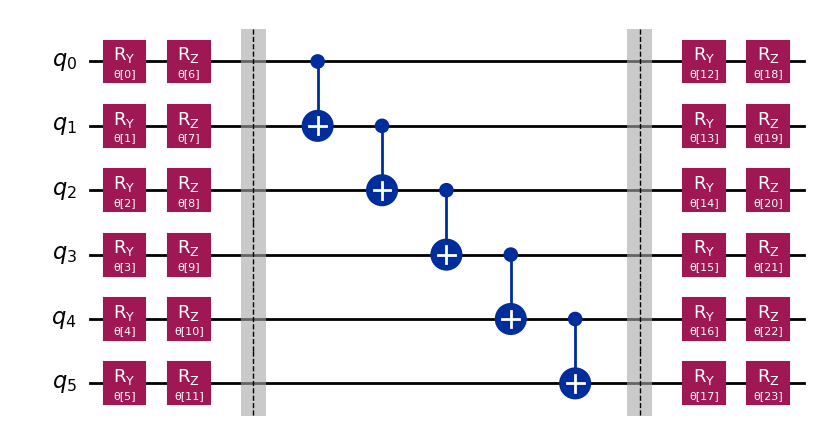

In [77]:
np.random.seed(1)
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 
initial_point = np.random.random(ansatz.num_parameters)
ansatz.decompose().draw('mpl', style='iqx')

In [78]:
optimizer=SPSA(maxiter=maxiter)
vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=quantum_instance,
                callback=callback)

In [79]:
for k in range(len(b)):
    
    hamiltonian=H_ising(num_qubits,J,b[k])
    
    # Extract eig
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    y_error_6.append(np.mean(intermediate_info['stddev']))
    energy_6.append(result.eigenvalue)

In [80]:
nShots = 8192
J = -1
b = np.linspace(0,4,10)

num_qubits=7
E_l_7 = []
P_l_7 = []
energy_levels_7 = []

for k in range(len(b)):
    hamiltonian=Operator(H_ising(num_qubits,J,b[k]))
    
    # Extract eig
    E_l_7,P_l_7 = linalg.eig(hamiltonian.data)

    Es_7 = np.sort(E_l_7)

    energy_levels_7.append(np.real(Es_7))

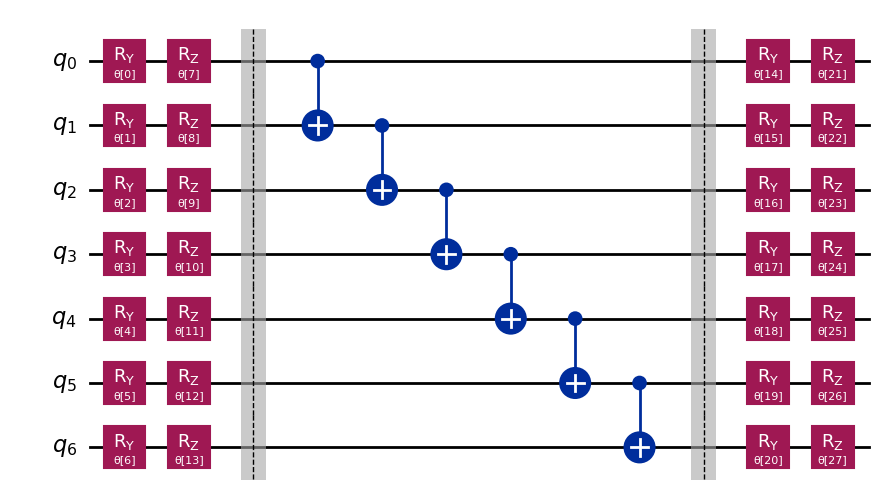

In [81]:
np.random.seed(1)
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 
initial_point = np.random.random(ansatz.num_parameters)
ansatz.decompose().draw('mpl', style='iqx')

In [82]:
optimizer=SPSA(maxiter=maxiter)
vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=quantum_instance,
                callback=callback)

In [83]:
for k in range(len(b)):
    
    hamiltonian=H_ising(num_qubits,J,b[k])
    
    # Extract eig
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    y_error_7.append(np.mean(intermediate_info['stddev']))
    energy_7.append(result.eigenvalue)

C:\Users\Fabio\anaconda3\lib\site-packages\matplotlib\collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


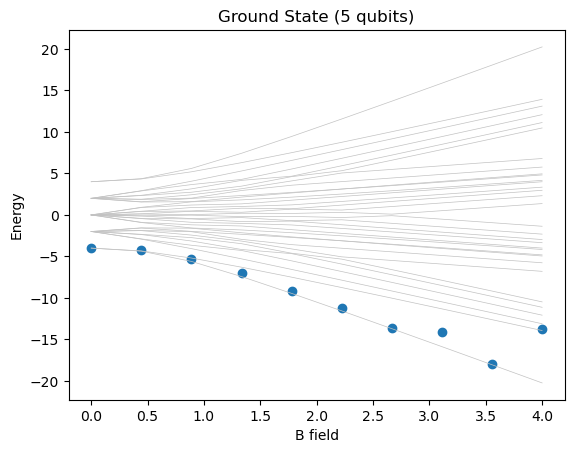

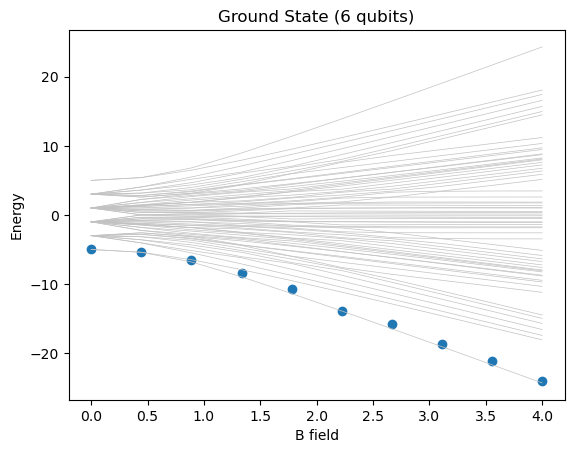

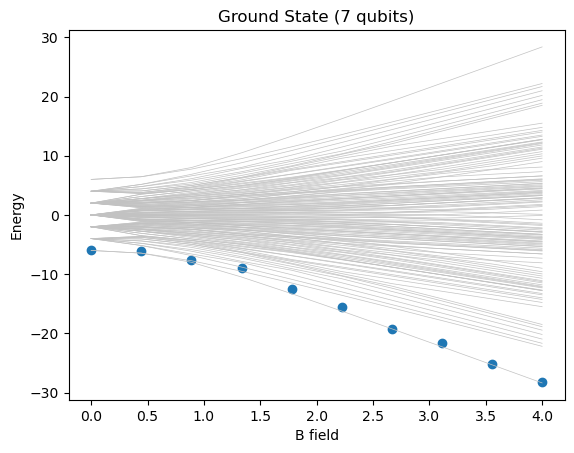

In [85]:
fig1, a5 = plt.subplots()
fig2, a6 = plt.subplots()
fig3, a7 = plt.subplots()


a5.scatter(b, energy_5)
a5.plot(b, energy_levels_5, color="#c2c2c2", linewidth=.5)
a5.set(xlabel='B field', ylabel='Energy', title='Ground State (5 qubits)')

a6.scatter(b, energy_6)
a6.plot(b, energy_levels_6, color="#c2c2c2", linewidth=.5)
a6.set(xlabel='B field', ylabel='Energy', title='Ground State (6 qubits)')

a7.scatter(b, energy_7)
a7.plot(b, energy_levels_7, color="#c2c2c2", linewidth=.5)
a7.set(xlabel='B field', ylabel='Energy', title='Ground State (7 qubits)')

plt.show()

### Varying J

We have reasoned with a ferromagnetic Ising model, i.e. with all $J_{\langle i j \rangle}<0$    (we have also assumed that $J_{\langle i j \rangle}=J$ are all equal).  
In a ferromagnetic Ising model, spins desire to be aligned: the configurations in which adjacent spins are of the same sign have higher probability. In an antiferromagnetic model, adjacent spins tend to have opposite signs.  
Let's take a look at the latter case.

In [86]:
nShots = 8192
J = 1
b = np.linspace(0,4,10)

num_qubits=4
E_l_plus = []
P_l_plus = []
energy_levels_plus = []

for k in range(len(b)):
    hamiltonian=Operator(H_ising(num_qubits,J,b[k]))
    
    # Extract eig
    E_l_plus,P_l_plus = linalg.eig(hamiltonian.data)

    Es_plus = np.sort(E_l_plus)

    energy_levels_plus.append(np.real(Es_plus))

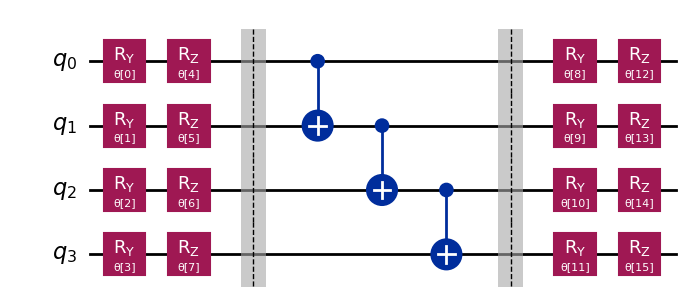

In [87]:
np.random.seed(1)
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 
initial_point = np.random.random(ansatz.num_parameters)
ansatz.decompose().draw('mpl', style='iqx')

In [88]:
maxiter=75

optimizer=SPSA(maxiter=maxiter)
vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=quantum_instance,
                callback=callback)

energy_plus=[]
y_error_plus=[]

for k in range(len(b)):
    
    hamiltonian=H_ising(num_qubits,J,b[k])
    
    # Extract eig
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    y_error_plus.append(np.mean(intermediate_info['stddev']))
    energy_plus.append(result.eigenvalue)

C:\Users\Fabio\anaconda3\lib\site-packages\matplotlib\collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


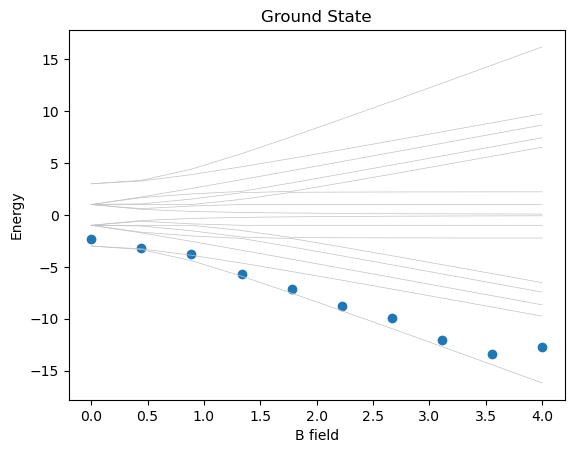

In [89]:
fig, ax= plt.subplots()

ax.scatter(b, energy_plus)
ax.plot(b, energy_levels_plus, color="#c2c2c2", linewidth=.5)
ax.set(xlabel='B field', ylabel='Energy', title='Ground State')

plt.show()

In [92]:
print(P_l_plus)

[[ 2.06425720e-01+0.j  3.00342822e-01+0.j  1.02072431e-01+0.j
  -4.39531086e-01+0.j -5.28764207e-01+0.j -1.29622749e-01+0.j
  -8.58934950e-02+0.j  5.78993676e-01+0.j  1.13874176e-01+0.j
  -1.07721464e-01+0.j -1.45688186e-17+0.j  1.44981502e-16-0.j
  -1.87032397e-16+0.j  4.83701365e-17-0.j -8.98592091e-17+0.j
   1.99942776e-16-0.j]
 [-2.32260088e-01+0.j  2.62845295e-01+0.j  1.62076860e-01+0.j
   3.13258355e-01-0.j -2.81793567e-01+0.j  2.14924824e-01+0.j
   1.54420832e-02-0.j -4.06559202e-02+0.j -2.69971741e-01+0.j
  -2.28454590e-01+0.j  1.64216599e-01-0.j  2.86861837e-01-0.j
  -3.10906970e-01+0.j  2.09952498e-01-0.j -9.88121680e-17+0.j
  -5.00000000e-01+0.j]
 [-2.62845295e-01+0.j  2.32260088e-01+0.j -3.10906970e-01+0.j
   2.09952498e-01-0.j -1.64216599e-01+0.j -2.86861837e-01+0.j
   4.06559202e-02-0.j -1.54420832e-02+0.j  2.28454590e-01+0.j
   2.69971741e-01+0.j -2.81793567e-01+0.j  2.14924824e-01-0.j
  -1.62076860e-01+0.j -3.13258355e-01+0.j  5.00000000e-01+0.j
  -3.21865742e-16+0.j]
 